In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import rl_equation_solver
from rl_equation_solver.environment.algebraic import Env
from rl_equation_solver.agent.dqn import Agent as AgentDQN
from rl_equation_solver.agent.gcn import Agent as AgentGCN
from rl_equation_solver.agent.lstm import Agent as AgentLSTM
from rl_equation_solver.utilities import utilities
from rl_equation_solver.utilities.utilities import GraphEmbedding
from rl_equation_solver.agent.networks import ActorCritic
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from rex import init_logger
import torch
from sympy import (
    symbols,
    sqrt,
    simplify,
    expand,
    nsimplify,
    parse_expr,
    sympify,
)
import sympy
import cProfile, pstats, io
from pstats import SortKey
from rl_equation_solver.agent.a2c import Agent as AgentA2C

In [10]:
init_logger(__name__, log_level="INFO")
init_logger("rl_equation_solver", log_level="INFO")

<Logger rl_equation_solver (INFO)>

In [11]:
# plot reward distribution
def plot_reward_dist(env):
    _, ax = plt.subplots(1, 1)
    ax.hist(env.avg_history["reward"])
    ax.set_ylabel("Count")
    ax.set_xlabel("Reward")
    plt.show()


# plot complexity, loss, reward
def plot_trends(env):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax = axes.flatten()
    history = env.total_history
    x = np.arange(len(history["ep"]))

    y = history["complexity"]
    a, b = np.polyfit(x, y, 1)
    ax[0].scatter(x, y)
    ax[0].plot(a * x + b, color="r")

    y = history["loss"]
    mask = np.array([i for i, v in enumerate(y) if not np.isnan(v)])
    mask = slice(mask[0], mask[-1] + 1)
    a, b = np.polyfit(x[mask], y[mask], 1)
    ax[1].scatter(x[mask], y[mask])
    ax[1].plot(x[mask], a * x[mask] + b, color="r")

    y = history["reward"]
    a, b = np.polyfit(x, y, 1)
    ax[2].scatter(x, y)
    ax[2].plot(a * x + b, color="r")

    y = history["loop_step"]
    a, b = np.polyfit(x, y, 1)
    ax[3].scatter(x, y)
    ax[3].plot(a * x + b, color="r")

    ax[0].set_title("Complexity")
    ax[1].set_title("Loss")
    ax[2].set_title("Reward")
    ax[3].set_title("Steps")

    plt.show()

## Initialize Env and Agent ##
### Agent can be AgentGCN, AgentLSTM, AgentDQN ###

In [12]:
env = Env(order=3, config={"reward_function": "diff_loss_reward"})

INFO - 2023-05-06 04:58:56,519 [algebraic.py:116] : Initializing environment with order=3, |S| = 20 x 128 = 2560
INFO - 2023-05-06 04:58:56,519 [algebraic.py:121] : Using reward function: diff_loss_reward.


In [ ]:
config = {"learning_rate": 5e-4, "device": "cuda:0", "update_freq": 10, 'grad_clip': 100, 'max_solution_steps': 200}

In [15]:
agent = AgentA2C(env=env, config=config)

{'ep': '0   ', 'step': '3907', 'loop_step': '3907', 'complexity': '5.50e+01 ', 'loss': '1.88e+02 ', 'reward': '-3.30e+01', 'previous_state': '0                   ', 'state': 'a0                  '}: : 0it [05:20, ?it/s]

INFO - 2023-05-06 05:04:24,832 [base.py:83] : Initialized Agent with config: {'batch_size': 32, 'gamma': 0.9, 'eps_start': 0.9, 'eps_end': 0.05, 'eps_decay_steps': 1000, 'tau': 0.005, 'learning_rate': 0.0005, 'hidden_size': 64, 'memory_cap': 10000, 'fill_memory_steps': 64, 'reset_steps': 100, 'state_dim': 128, 'feature_num': 100, 'grad_clip': 100, 'reward_function': 'diff_loss_reward', 'max_solution_steps': 200, 'device': 'cuda:0', 'entropy_coef': 0.05, 'critic_coef': 0.6, 'update_freq': 10}
INFO - 2023-05-06 05:04:24,833 [base.py:70] : Initialized Agent with device cuda:0


In [ ]:
agent.update_config(config)

## Train Agent ##

In [17]:
for _ in range(1):
    agent.train(100, progress_bar=True)

INFO - 2023-05-06 05:04:43,241 [base.py:243] : Running training routine for 100 episodes in eval=False mode.


{'ep': '0   ', 'step': '73  ', 'loop_step': '73  ', 'complexity': '3.70e+01 ', 'loss': '5.45e+02 ', 'reward': '-8.00e+00', 'previous_state': '0**a2               ', 'state': '(0**a2)**a1         '}: : 0it [00:10, ?it/s]
{'ep': '0   ', 'step': '274 ', 'loop_step': '200 ', 'complexity': '5.30e+01 ', 'loss': '2.60e+03 ', 'reward': '-1.00e+00', 'previous_state': '-a2                 ', 'state': '-a2/a1              '}: : 0it [00:15, ?it/s]

INFO - 2023-05-06 05:04:59,327 [algebraic.py:456] : loop_step 201 exceeded max 200


{'ep': '1   ', 'step': '476 ', 'loop_step': '200 ', 'complexity': '4.30e+01 ', 'loss': '9.55e+02 ', 'reward': '-4.00e+00', 'previous_state': '0**a1               ', 'state': '(0**a1)**0.5        '}: : 1it [00:32, 16.04s/it]    

INFO - 2023-05-06 05:05:15,852 [algebraic.py:456] : loop_step 201 exceeded max 200


{'ep': '2   ', 'step': '678 ', 'loop_step': '200 ', 'complexity': '4.70e+01 ', 'loss': '2.43e+03 ', 'reward': '3.90e+01 ', 'previous_state': 'a0 + a2             ', 'state': 'a2                  '}: : 2it [00:49, 16.33s/it]   

INFO - 2023-05-06 05:05:33,060 [algebraic.py:456] : loop_step 201 exceeded max 200


{'ep': '3   ', 'step': '880 ', 'loop_step': '200 ', 'complexity': '6.00e+01 ', 'loss': '1.21e+03 ', 'reward': '-2.40e+01', 'previous_state': '0                   ', 'state': '1                   '}: : 3it [01:06, 16.73s/it]              

INFO - 2023-05-06 05:05:49,521 [algebraic.py:456] : loop_step 201 exceeded max 200


{'ep': '4   ', 'step': '1082', 'loop_step': '200 ', 'complexity': '4.60e+01 ', 'loss': '1.70e+03 ', 'reward': '-1.00e+00', 'previous_state': '((0**a2)**a2)**a2   ', 'state': '(((0**a2)**a2)**a2)**0.5'}: : 4it [01:22, 16.62s/it]                                 

INFO - 2023-05-06 05:06:05,651 [algebraic.py:456] : loop_step 201 exceeded max 200


{'ep': '5   ', 'step': '1284', 'loop_step': '200 ', 'complexity': '8.60e+01 ', 'loss': '2.63e+03 ', 'reward': '-3.80e+01', 'previous_state': 'a0                  ', 'state': 'a0 + 1              '}: : 5it [01:38, 16.45s/it]    

INFO - 2023-05-06 05:06:22,337 [algebraic.py:456] : loop_step 201 exceeded max 200


{'ep': '6   ', 'step': '1486', 'loop_step': '200 ', 'complexity': '5.40e+01 ', 'loss': '9.49e+02 ', 'reward': '-3.30e+01', 'previous_state': '0                   ', 'state': '-a1                 '}: : 6it [01:56, 16.53s/it]

INFO - 2023-05-06 05:06:39,396 [algebraic.py:456] : loop_step 201 exceeded max 200


{'ep': '7   ', 'step': '1688', 'loop_step': '200 ', 'complexity': '5.20e+01 ', 'loss': '3.93e+02 ', 'reward': '-3.10e+01', 'previous_state': '0                   ', 'state': '-a2                 '}: : 7it [02:12, 16.70s/it]  

INFO - 2023-05-06 05:06:56,051 [algebraic.py:456] : loop_step 201 exceeded max 200


{'ep': '8   ', 'step': '1735', 'loop_step': '45  ', 'complexity': '5.90e+01 ', 'loss': '1.89e+03 ', 'reward': '-3.00e+01', 'previous_state': '0**a1               ', 'state': '0**a1 + a1          '}: : 8it [02:16, 16.69s/it]

## Plot Reward Distribution ##

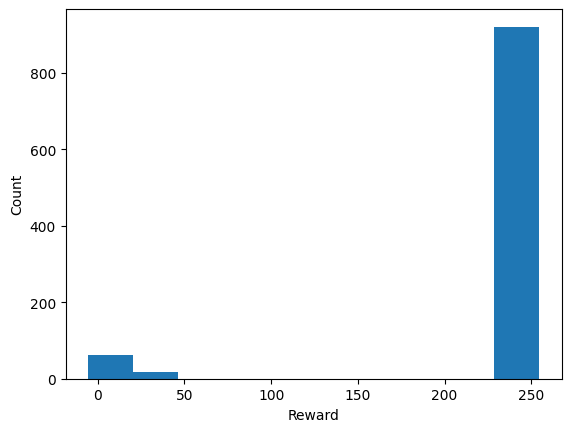

In [8]:
plot_reward_dist(env)

## Plot complexity, loss, and reward trend ##

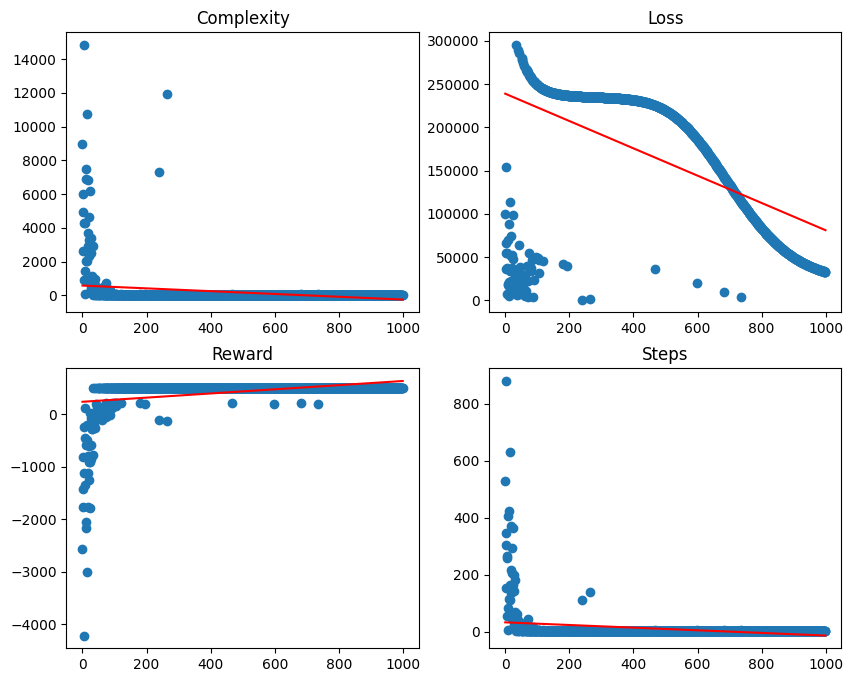

In [9]:
plot_trends(env)

## Run trained agent in eval mode ##

In [10]:
agent.train(10, eval=True)

INFO - 2023-04-27 18:27:12,517 [base.py:231] : Running training routine for 10 episodes in eval=True mode.


{'ep': '109 ', 'step': '2950', 'loop_step': '1   ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '5.18e+02 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}: : 10it [00:00, 14.83it/s]


In [11]:
history = env.best_history
best_i = np.argmax(history["reward"])
print(parse_expr(str(history["state"][best_i])))
print(history["reward"][best_i])

-a1/a0
518.0


c:\users\bbent\repos\rl-equation-solver\rl_equation_solver\utilities\history.py:114: RuntimeWarning: All-NaN axis encountered
  out[k].append(np.nanmin(series[k]))


## Plot reward distribution for trained agent ##

c:\users\bbent\repos\rl-equation-solver\rl_equation_solver\utilities\history.py:100: RuntimeWarning: Mean of empty slice
  out[k].append(np.nanmean(series[k]))


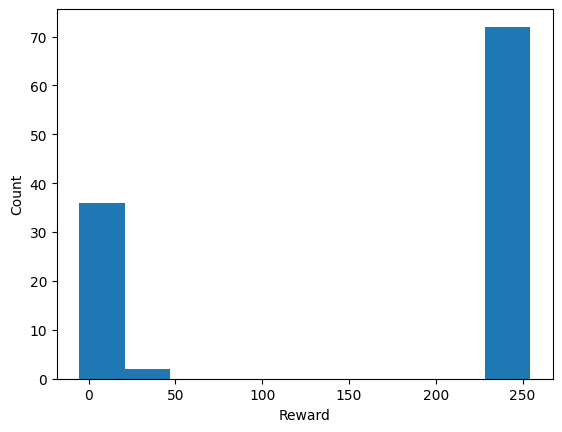

In [12]:
plot_reward_dist(env)

## Render final state graph ##

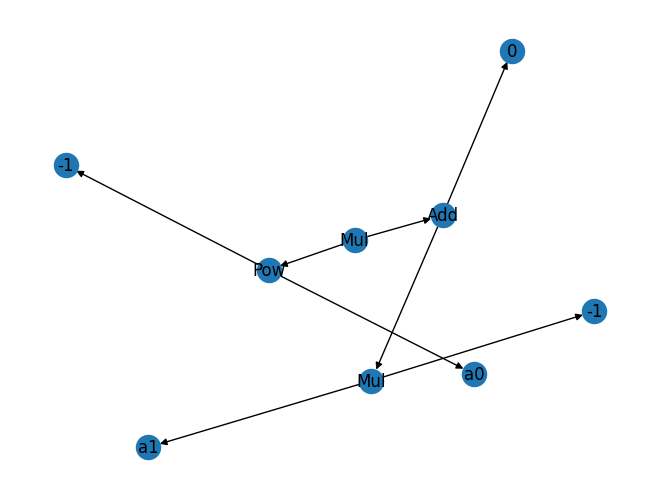

In [13]:
nx.draw(env.state_graph, labels=env.node_labels)

## Run new Agent in eval mode ##

In [150]:
env = Env(order=2)
agent = AgentGCN(env, device="cuda:0")
agent.train(30, eval=True)

INFO - 2023-04-17 13:10:35,160 [algebraic.py:112] : Initializing environment with order=2, |S| = 11 x 64 = 704
INFO - 2023-04-17 13:10:35,163 [gcn.py:37] : Initialized Agent with device cuda:0
INFO - 2023-04-17 13:10:35,169 [base.py:298] : Running training routine for 30 episodes in eval=True mode.
INFO - 2023-04-17 13:10:35,194 [history.py:76] : 
{'ep': 0, 'step': 1, 'complexity': 14.0, 'loss': 'nan', 'reward': '-8.000e+00', 'state': 1/a1, 'approx': a0/a1 + a1}
INFO - 2023-04-17 13:10:35,196 [base.py:347] : 
Solver terminated after 3 steps: total_reward = -1.700e+01, mean_loss = nan, state = 1/a1
INFO - 2023-04-17 13:10:35,306 [history.py:76] : 
{'ep': 1, 'step': 8, 'complexity': 18.0, 'loss': 'nan', 'reward': '-4.000e+00', 'state': a0 - a1, 'approx': a0*(a0 - a1) + a1}
INFO - 2023-04-17 13:10:35,309 [base.py:347] : 
Solver terminated after 8 steps: total_reward = -1.700e+01, mean_loss = nan, state = a0 - a1
INFO - 2023-04-17 13:10:35,344 [history.py:76] : 
{'ep': 2, 'step': 11, 'comp

## Plot reward distribution for untrained agent ##

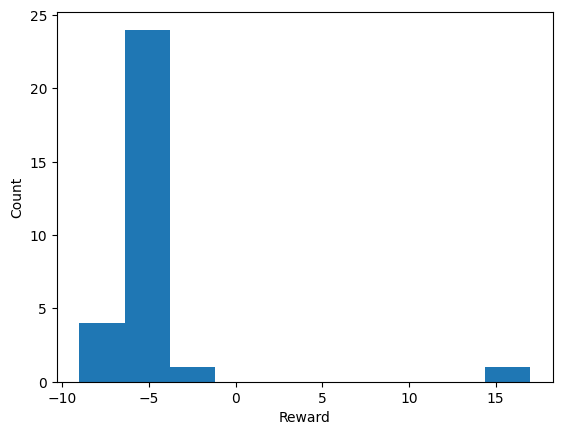

In [151]:
plot_reward_dist(env)